In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [ ]:
# Load the Cats vs Dogs dataset
(ds_train, ds_test), ds_info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.Q1KIMF_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
# Function to preprocess images
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))  # Resize images to 128x128
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  # Preprocess for MobileNetV2
    return image, label

In [ ]:
# Apply preprocessing
ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Load a pre-trained MobileNetV2 model for feature extraction
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,  # Exclude the fully connected layers at the top
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

In [ ]:
# Define a function to extract features using the pre-trained model
def extract_features(dataset):
    features, labels = [], []
    for images, lbls in dataset:
        # Extract features using MobileNetV2
        extracted_features = base_model(images)
        extracted_features = tf.keras.layers.GlobalAveragePooling2D()(extracted_features)
        features.extend(extracted_features.numpy())
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

In [ ]:
# Extract features for training and testing datasets
train_features, train_labels = extract_features(ds_train)
test_features, test_labels = extract_features(ds_test)

In [ ]:
# Train an SVM model on the extracted features
svm_model = SVC(kernel='linear', C=1.0, random_state=42)  # Linear kernel for simplicity
svm_model.fit(train_features, train_labels)

SVC(kernel='linear', random_state=42)

In [ ]:
# Predict using the SVM model
test_predictions = svm_model.predict(test_features)

In [ ]:
# Evaluate the model
print("Accuracy on test set: {:.2f}%".format(accuracy_score(test_labels, test_predictions) * 100))
print("\nClassification Report:\n", classification_report(test_labels, test_predictions, target_names=['Cat', 'Dog']))

Accuracy on test set: 96.82%

Classification Report:
               precision    recall  f1-score   support

         Cat       0.97      0.97      0.97      2280
         Dog       0.97      0.97      0.97      2372

    accuracy                           0.97      4652
   macro avg       0.97      0.97      0.97      4652
weighted avg       0.97      0.97      0.97      4652



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

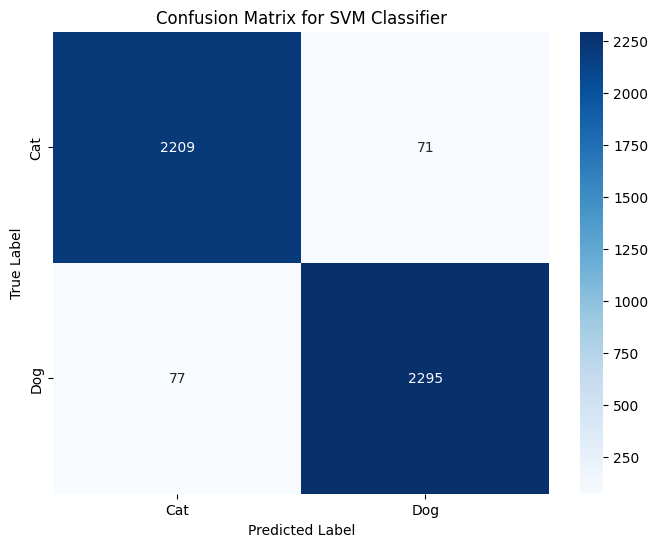

In [ ]:
# 1. Confusion Matrix Visualization
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix for SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# 2. Visualize Sample Images with Predictions
def plot_sample_predictions(dataset, model, num_samples=5):
    plt.figure(figsize=(15, 10))
    for idx, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(1, num_samples, idx + 1)
        img = tf.image.resize(image, (128, 128))
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        features = base_model(tf.expand_dims(img, axis=0))
        features = tf.keras.layers.GlobalAveragePooling2D()(features)
        prediction = model.predict(features.numpy())[0]
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"True: {'Cat' if label.numpy() == 0 else 'Dog'}\nPred: {'Cat' if prediction == 0 else 'Dog'}")
        plt.axis('off')
        plot_sample_predictions(ds_test.unbatch().batch(1), svm_model, num_samples=5)

In [ ]:
# 3. Feature Visualization using PCA or t-SNE
def visualize_features(features, labels, method='pca'):
    if method == 'pca':
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features)
    elif method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette='viridis', alpha=0.6)
    plt.title(f'Feature Visualization using {method.upper()}')
    plt.xlabel(f'{method.upper()} Component 1')
    plt.ylabel(f'{method.upper()} Component 2')
    plt.legend(['Cat', 'Dog'])
    plt.show()

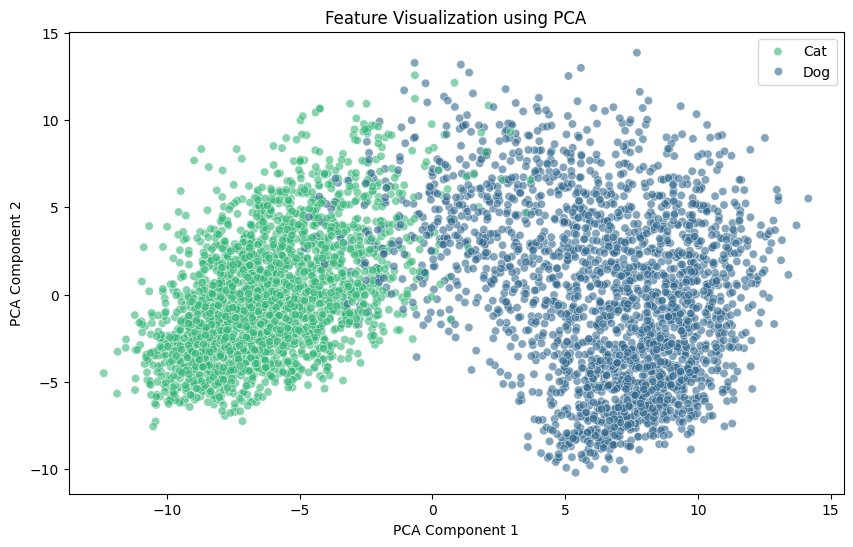

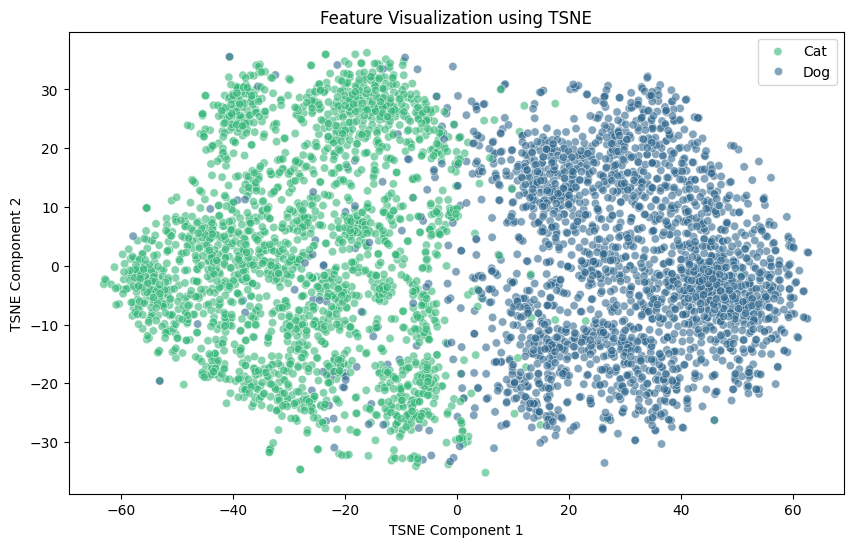

In [ ]:
# Visualize features with PCA
visualize_features(test_features, test_labels, method='pca')

# Visualize features with t-SNE
visualize_features(test_features, test_labels, method='tsne')